In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm, norm
from scipy.optimize import fmin_slsqp
import qvalue as qv

In [2]:
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)

new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Negative')) else False, axis = 1)

new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Positive')) else False, axis = 1)




In [3]:
full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)

In [4]:
full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)
for i in full_df['Integrative Cluster'].unique():
    if type(i) == str:
        full_df[f'Intclust {i} or not'] = full_df.apply(lambda row: i if (row['Integrative Cluster'] == i) else 'Not', axis = 1)


In [5]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import qvalue as qv

clusterframes = {}


for i in full_df['Integrative Cluster'].unique():
    if type(i) == str:
        df_cluster = pd.DataFrame(index=pca_per_pathway.columns) 
        pvaluelist = []
        for pathway in df_cluster.index:
            results = ols("Q(pathway) ~ C(Q(f'Intclust {i} or not'))", data=full_df).fit()
            table = sm.stats.anova_lm(results, typ=2)
            pvalue = table['PR(>F)'][0]
            pvaluelist.append(pvalue)
    
        df_cluster['p-values'] = pvaluelist
        qv.qvalues(df_cluster, 'p-values', 'qvalues')
        print(i)
        clusterframes[i] = df_cluster

4ER+
9
7
3
8
10
1
2
5
4ER-
6


In [6]:
significant_pathways = {}
def failures_of_null_anova(cluster, my_xa, my_xb, iterations=10000):
    pvalues = clusterframes[cluster]['p-values'].tolist()
    pvalues = [0.999 if x == 1.0 else x for x in pvalues] ##pathways with p-val 1 gave error as range would be to inf
    pvalues = sorted(pvalues)
    z_scores = norm.ppf(pvalues)
    print(z_scores)
    xa = np.percentile(z_scores, my_xa)
    xb = np.percentile(z_scores, my_xb)
    print(f'Quantiles calculated: {xa}, {xb}')


    trunc_z = z_scores[z_scores>xa]
    trunc_z = trunc_z[trunc_z<xb]

    def func(p, r, xa, xb):
        return truncnorm.nnlf(p, r)

    def constraint(p, r, xa, xb):
        a, b, loc, scale = p
        return np.array([a*scale + loc - xa, b*scale + loc - xb])

    loc_guess = np.median(z_scores)
    scale_guess = np.std(z_scores)
    a_guess = (xa - loc_guess)/scale_guess
    b_guess = (xb - loc_guess)/scale_guess
    p0 = [a_guess, b_guess, loc_guess, scale_guess]

    par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(trunc_z, xa, xb), iter=iterations)
    print(par)

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.hist(z_scores, bins=50, density=True)
    ax.plot(z_scores, truncnorm.pdf(z_scores, par[0], par[1], par[2], par[3]), 'r-', lw=5, alpha=0.6, label='truncnorm pdf')
    ax.plot(z_scores, norm.pdf(z_scores, par[2], par[3]), 'g-', lw=5, alpha=0.6, label='norm pdf')
    #ax.plot(z_scores, norm.sf(abs(z_scores-par[2]), 0, par[3])*2, 'y-', lw=5, alpha=0.6, label='norm sf')
    ax.set_xlabel("Z-Score")
    ax.set_ylabel('Frequency')
    ax.legend(loc='best')
    plt.savefig('newsfplot.png')
    plt.show()

    p_vals = norm.sf(abs(z_scores-par[2]), 0, par[3])*2

    plt.figure(figsize=(15, 10))
    plt.hist(p_vals, bins=30)
    plt.show()
    #print(pvalues[:10])
    print(p_vals[:20])
    sig_pathways = p_vals[p_vals < 0.001].size
    significant_pathways[cluster] = sig_pathways
    print(f'number of pathways with p < 0.001: {p_vals[p_vals < 0.001].size}')
    
    
    ##let's add to clusterframes
    clusterframes[cluster]['adjusted p-value'] = p_vals
    qv.qvalues(clusterframes[cluster], 'adjusted p-value', 'adjusted q-values')
    
    ##and log fold change
    clusterframes[cluster]['log adjusted p-value'] = -np.log10(clusterframes[cluster]['adjusted p-value'])
    clusterframes[cluster][f'cluster {cluster} log adjusted q-value'] = -np.log10(clusterframes[cluster]['adjusted q-values'])

In [7]:
clusterframes['7']

,p-values,qvalues
Ion channel transport,1.640604e-38,3.402613e-35
Cytosolic iron-sulfur cluster assembly,1.824016e-37,1.891505e-34
Activation of NMDA receptors and postsynaptic events,8.506606e-32,4.992945e-29
Ubiquinol biosynthesis,9.629594e-32,4.992945e-29
Post NMDA receptor activation events,1.584346e-31,6.297383e-29
...,...,...
NR1H2 & NR1H3 regulate gene expression linked to gluconeogenesis,9.939880e-01,9.959087e-01
Diseases associated with visual transduction,9.970615e-01,9.985059e-01
Defective Mismatch Repair Associated With MSH6,9.979216e-01,9.988191e-01
Retinoid cycle disease events,9.983375e-01,9.988191e-01


[-13.9119998  -13.27006612 -13.16634135 ...   2.88812157   3.04851915
   3.08715614]
Quantiles calculated: -2.291083602220969, 3.0791466944178243
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1538.8575709412817
            Iterations: 96
            Function evaluations: 777
            Gradient evaluations: 96
[-1.14953779  2.85766569 -0.75053727  1.34014415]


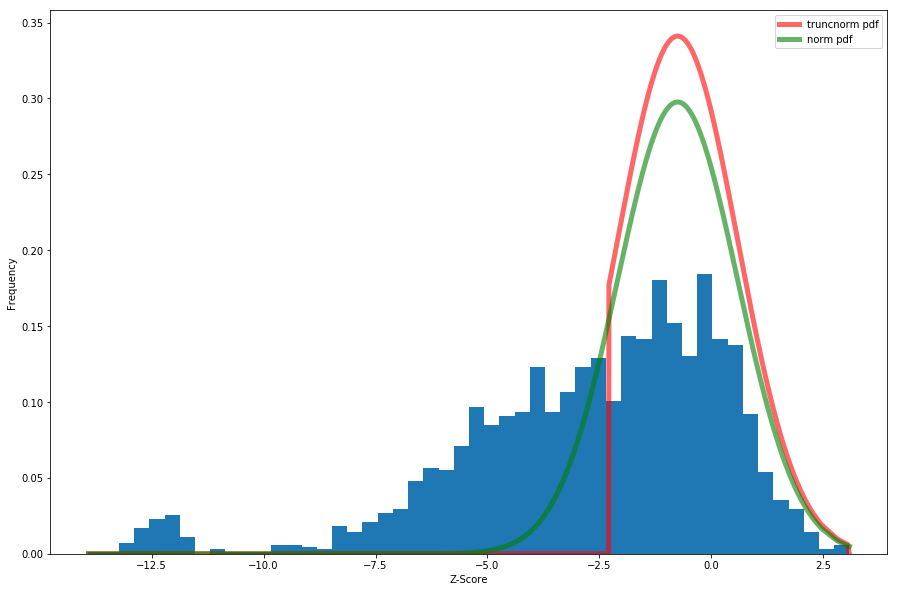

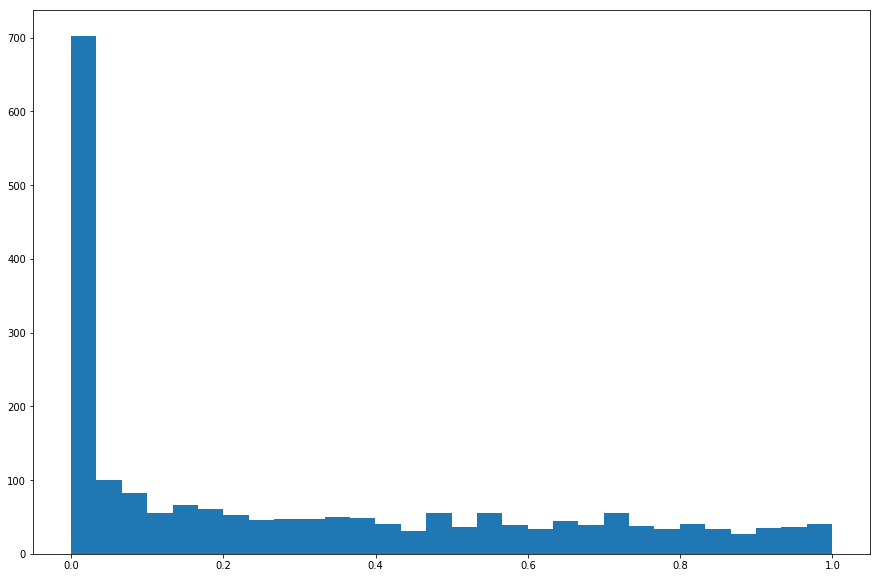

[9.14950625e-23 9.45964834e-21 1.95940514e-20 2.13192108e-20
 5.49454388e-20 5.49456505e-20 9.16925326e-20 1.38416445e-19
 2.27404409e-19 2.59502916e-19 3.56872191e-19 5.27217999e-19
 5.34051139e-19 5.51704001e-19 5.89821529e-19 6.20342384e-19
 9.85650632e-19 9.87419534e-19 9.87422806e-19 1.35552981e-18]
number of pathways with p < 0.001: 367


In [8]:
failures_of_null_anova('1', 48, 99.99)

[-6.84631661 -6.59458776 -6.57521133 ...  2.57862542  2.68407125
  2.84892587]
Quantiles calculated: -1.9487227015155724, 0.3343508380528847
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 929.6904342358471
            Iterations: 74
            Function evaluations: 554
            Gradient evaluations: 74
[-0.92896097  1.03500486 -0.86882295  1.16248129]


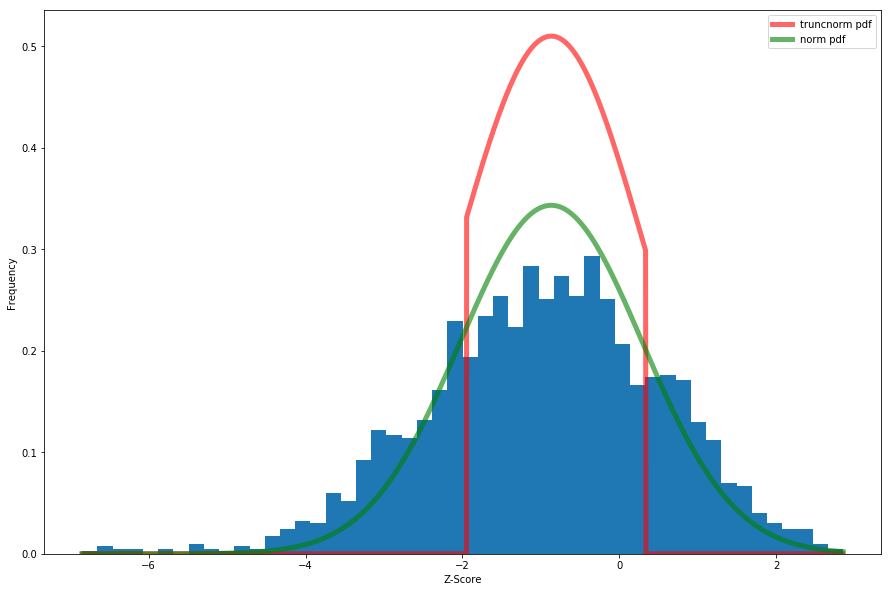

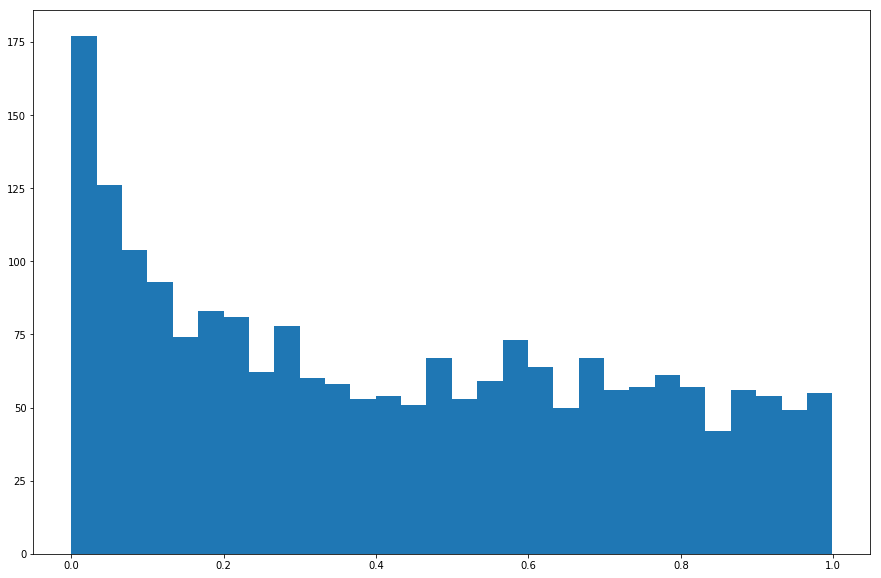

[2.71810621e-07 8.41585330e-07 9.16352836e-07 1.01615314e-06
 1.52860633e-06 2.68312739e-06 4.21111438e-06 6.16284886e-06
 1.68166494e-05 2.23711756e-05 7.48814606e-05 9.83709773e-05
 1.00831008e-04 1.04169541e-04 2.30456796e-04 2.30457006e-04
 4.02221742e-04 6.72645996e-04 6.72648391e-04 7.50504088e-04]
number of pathways with p < 0.001: 20


In [9]:
failures_of_null_anova('2', 25, 80)

[-14.83838977 -14.73374098 -14.67363221 ...   2.56879163   2.59389826
   2.59581911]
Quantiles calculated: -3.781479875312232, 1.7630456657758322
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2008.9868004777372
            Iterations: 129
            Function evaluations: 996
            Gradient evaluations: 129
[-0.8249283   1.80725401 -2.04382058  2.10643675]


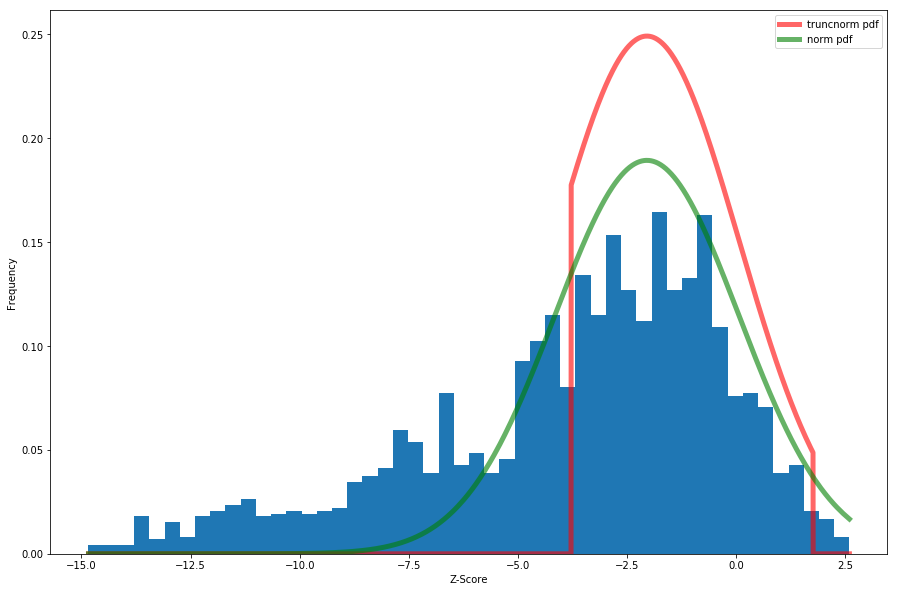

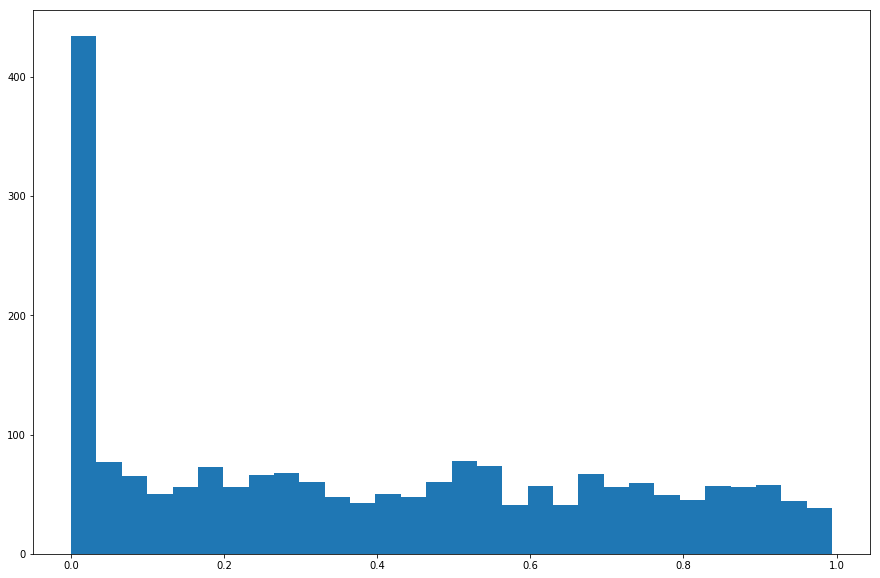

[1.24736015e-09 1.69786507e-09 2.02463517e-09 4.56644496e-09
 4.59747624e-09 5.58802370e-09 1.56768636e-08 1.82250708e-08
 1.82251575e-08 3.01678102e-08 3.08705229e-08 3.09214711e-08
 3.28677784e-08 3.39048439e-08 3.60641374e-08 3.73810059e-08
 4.36014589e-08 4.41365541e-08 4.45182756e-08 5.58083411e-08]
number of pathways with p < 0.001: 191


In [10]:
failures_of_null_anova('3', 40, 99, iterations=100000)

[-13.93086523 -12.3419182  -12.27722993 ...   2.36156958   2.43890359
   2.66449199]
Quantiles calculated: -4.327214793113503, 2.3524708098658613
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2442.6711492945687
            Iterations: 156
            Function evaluations: 1230
            Gradient evaluations: 156
[-1.11199312  1.94249663 -1.89546186  2.18684171]


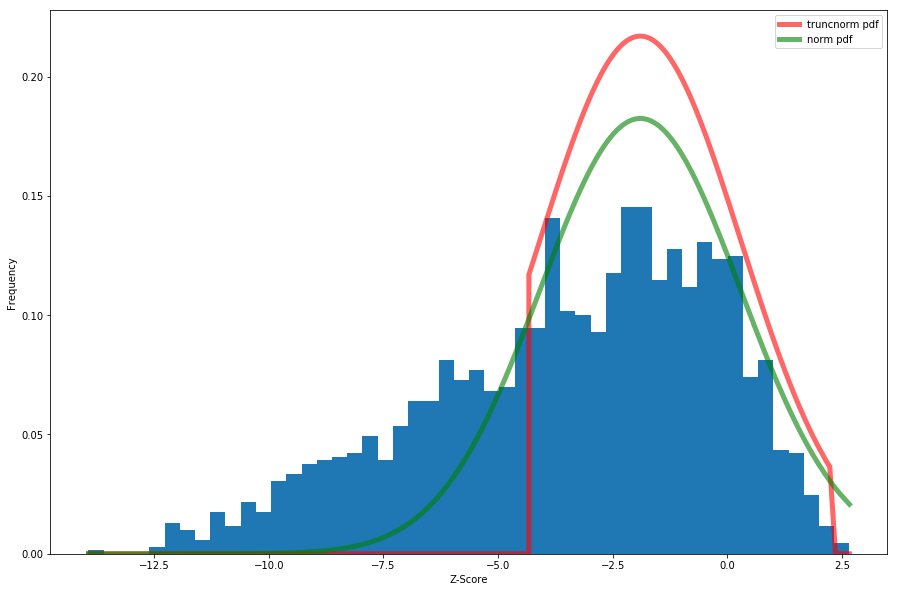

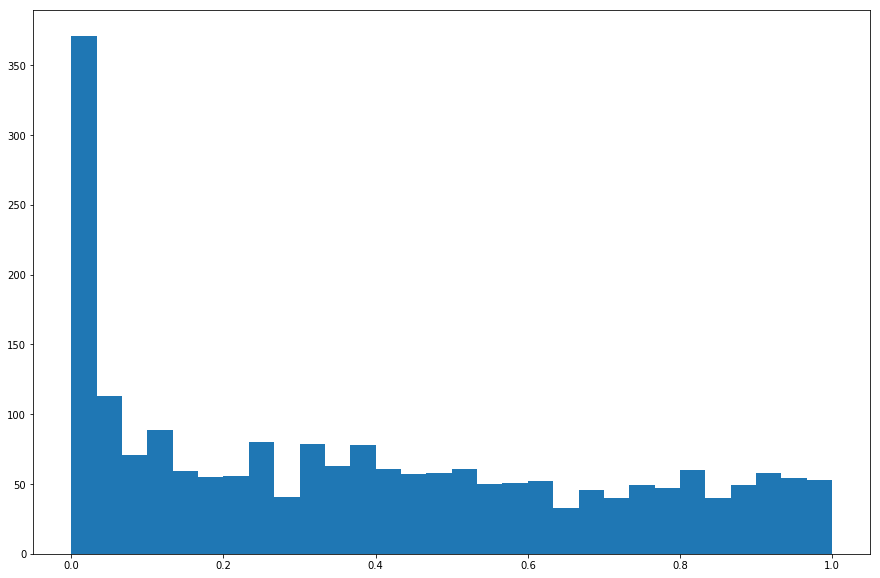

[3.72208610e-08 1.77964774e-06 2.06068829e-06 2.27199581e-06
 2.45215538e-06 2.46050543e-06 3.07938373e-06 3.12589994e-06
 3.80922182e-06 4.02724780e-06 4.08682033e-06 4.27393488e-06
 4.72223922e-06 4.84671758e-06 5.46946786e-06 6.36482982e-06
 7.67032431e-06 7.93823470e-06 8.11925656e-06 9.77824988e-06]
number of pathways with p < 0.001: 126


In [11]:
failures_of_null_anova('4ER-', 35, 99.9)

[-17.96216636 -16.73041369 -16.4718797  ...   2.74006575   2.74036923
   3.08908026]
Quantiles calculated: -4.724111263333868, 1.369161947331994
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1981.6688519263168
            Iterations: 321
            Function evaluations: 2543
            Gradient evaluations: 321
[-1.11152678  1.53667634 -2.16658979  2.30090856]


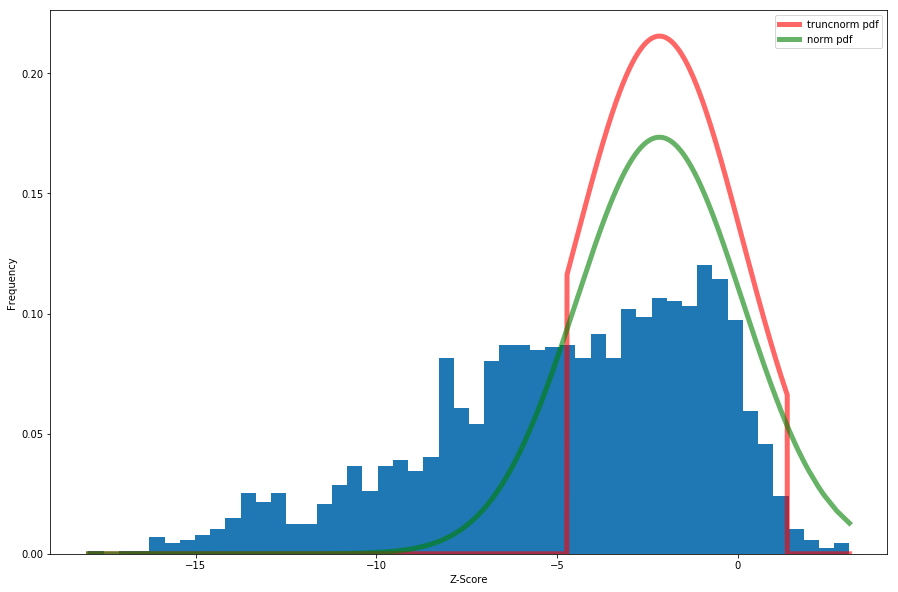

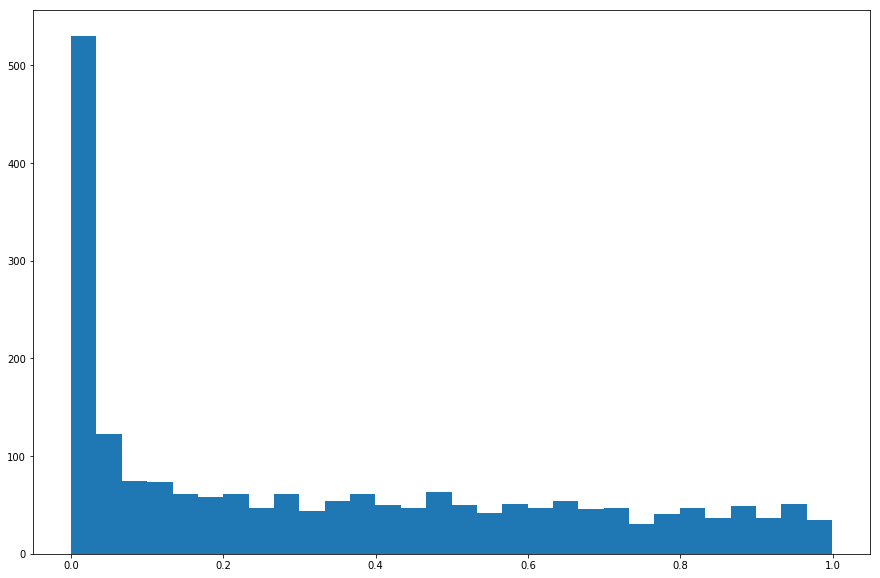

[6.65237894e-12 2.45802339e-10 5.05990722e-10 8.83164509e-10
 9.55178336e-10 9.56850118e-10 1.31470800e-09 1.66639703e-09
 1.69958032e-09 2.69845208e-09 3.55089641e-09 4.27270629e-09
 4.96926560e-09 8.84408560e-09 1.40734469e-08 1.42602939e-08
 1.76276419e-08 1.90405664e-08 2.90869878e-08 3.74566697e-08]
number of pathways with p < 0.001: 246


In [12]:
failures_of_null_anova('4ER+', 45, 99)

[-19.17431748 -18.97033885 -18.24982862 ...   2.78656516   2.90959138
   3.08069778]
Quantiles calculated: -4.640139573741501, 1.7418364317210873
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2918.014266703949
            Iterations: 92
            Function evaluations: 689
            Gradient evaluations: 92
[-1.57737078  1.77409807 -1.63645882  1.90423253]


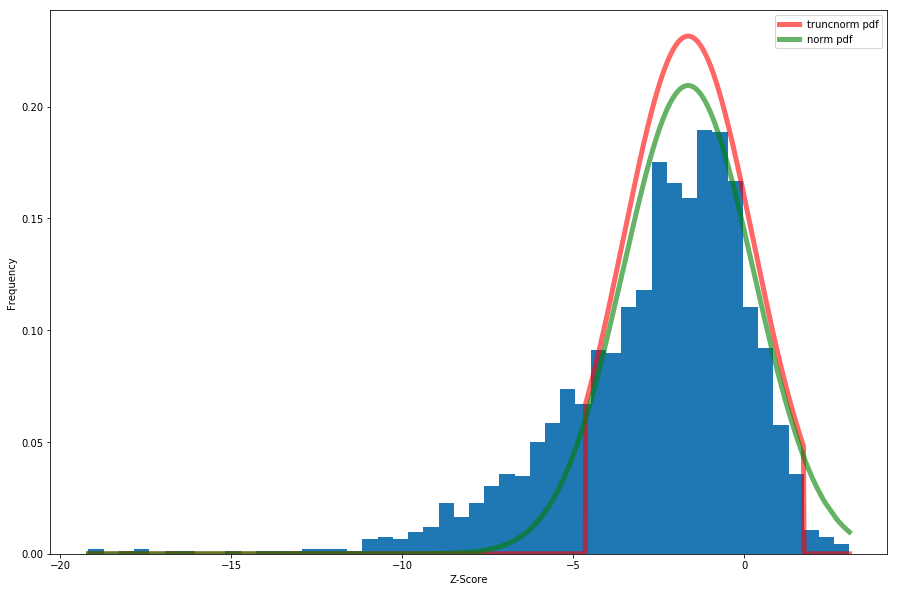

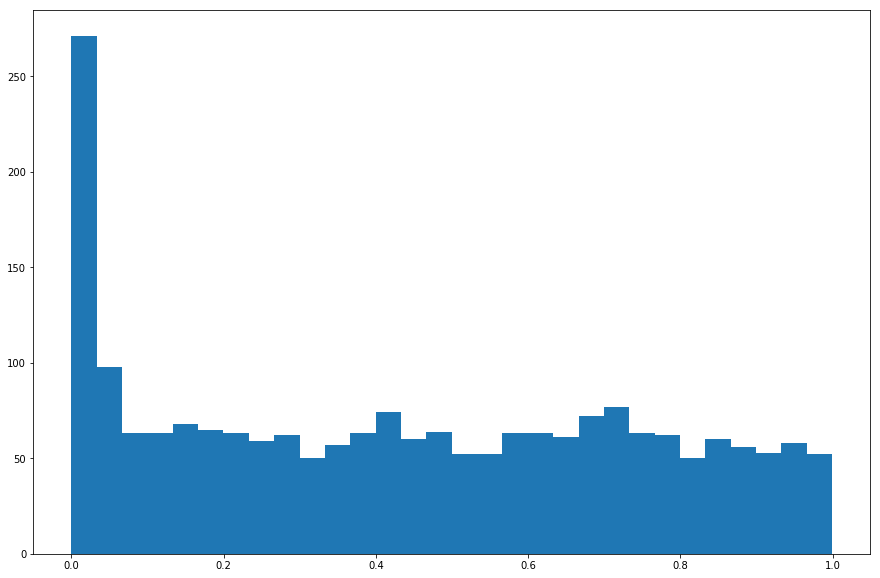

[3.26321116e-20 8.80187365e-20 2.67491944e-18 1.09009669e-16
 1.21300074e-16 1.37847678e-15 3.07048257e-14 3.56339450e-12
 3.24206914e-11 6.63878705e-10 2.63278300e-09 3.43011866e-09
 4.08051795e-09 1.57165784e-08 1.73462241e-08 7.05126644e-08
 1.23176920e-07 1.75835834e-07 5.89763477e-07 1.20354599e-06]
number of pathways with p < 0.001: 99


In [13]:
failures_of_null_anova('5', 20, 99)

[-33.62247858 -16.41150422  -9.77234282 ...   3.21698071   3.21743531
   3.21760124]
Quantiles calculated: -9.752152923372488, 3.2175668444235708
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4054.967041062971
            Iterations: 134
            Function evaluations: 1056
            Gradient evaluations: 134
[-4.7745304   2.62606722 -1.38467716  1.75252329]


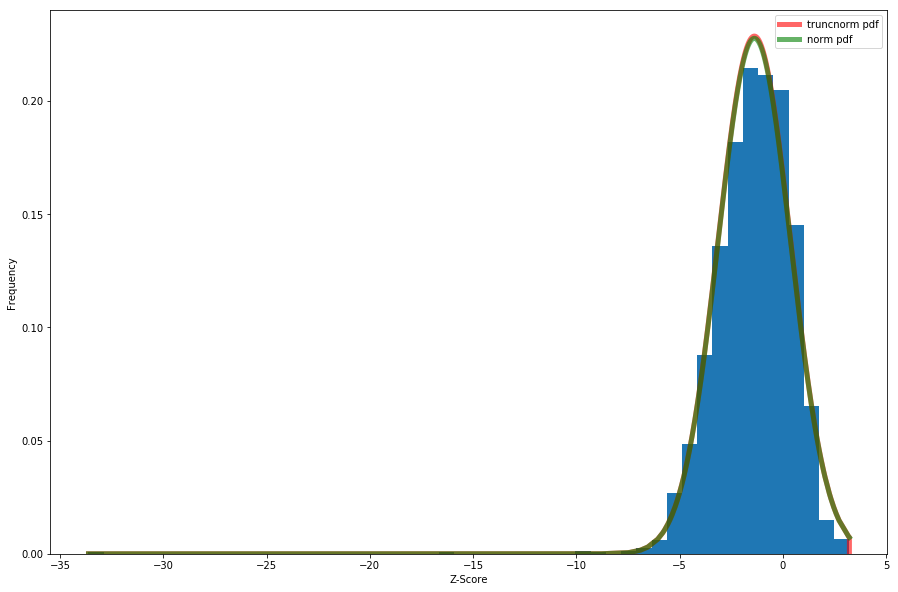

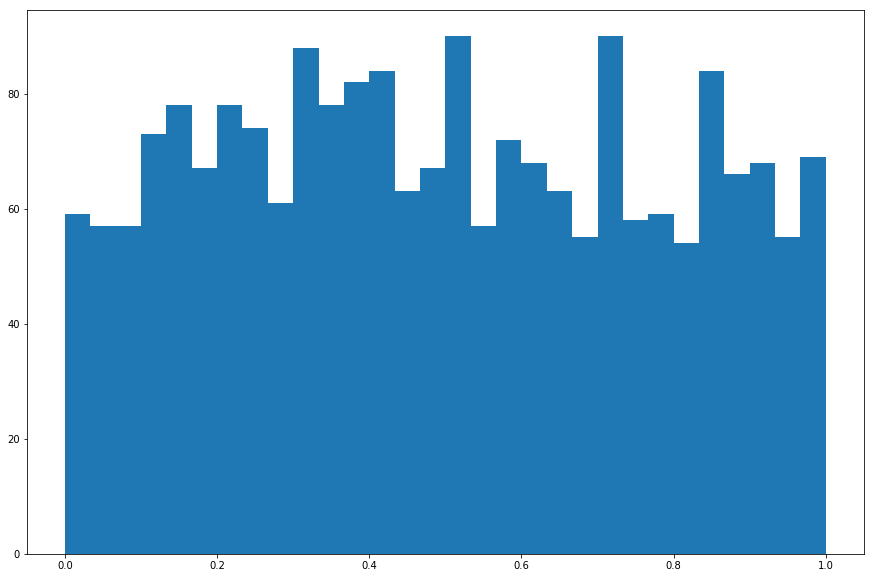

[1.43855551e-75 9.96089593e-18 1.70094944e-06 3.68793324e-06
 2.43433410e-05 4.68005161e-04 5.70539896e-04 1.55428877e-03
 1.60524882e-03 1.71833580e-03 3.23857754e-03 7.39130421e-03
 7.55764104e-03 1.07858226e-02 1.13353083e-02 1.15823727e-02
 1.19458958e-02 1.24444445e-02 1.31255413e-02 1.55538449e-02]
number of pathways with p < 0.001: 7


In [14]:
failures_of_null_anova('6', 0.1, 99.99)

[-12.92433509 -12.73774146 -11.67546537 ...   2.8660079    2.93598415
   3.2522174 ]
Quantiles calculated: -2.69715218026396, 3.18666225035813
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1211.184279918399
            Iterations: 137
            Function evaluations: 1048
            Gradient evaluations: 137
[-0.5151523   2.73202689 -1.76370799  1.81197713]


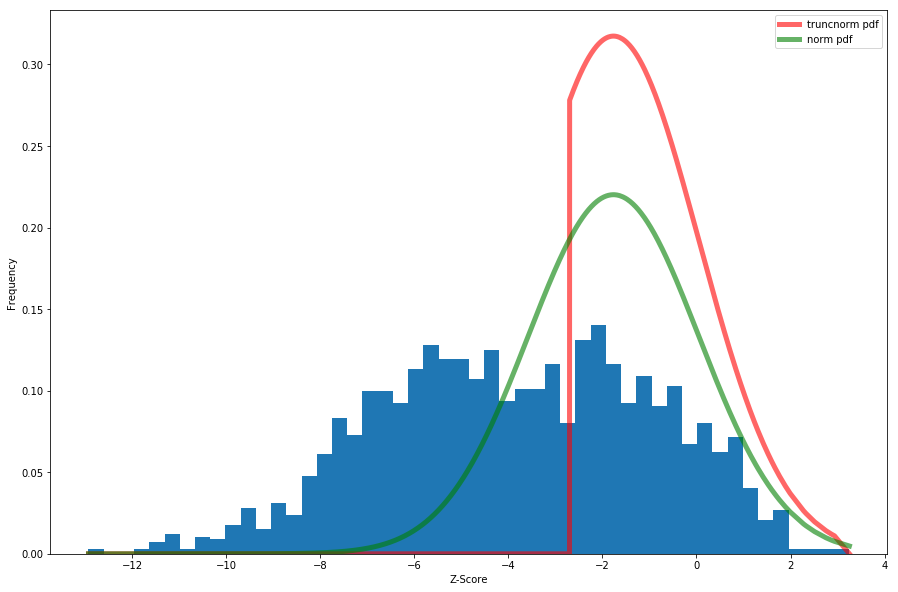

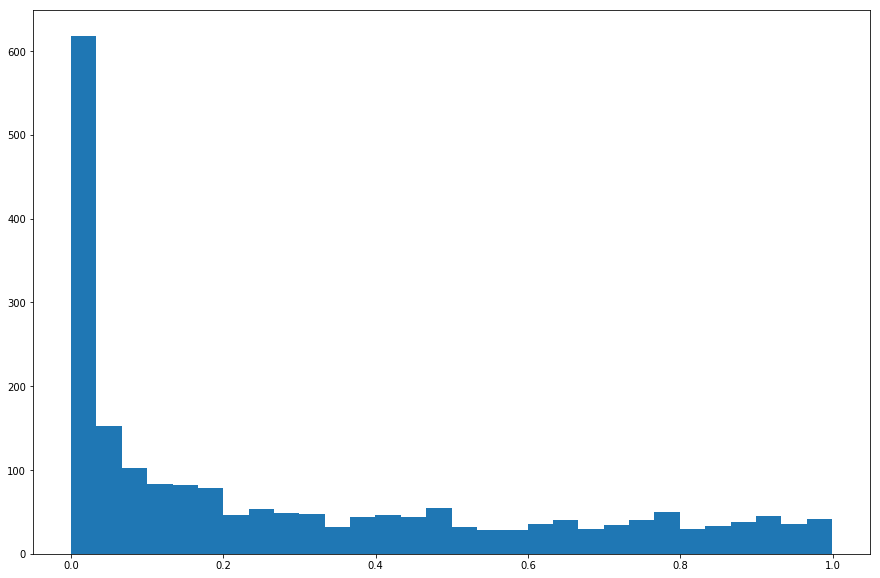

[7.30375688e-10 1.39213451e-09 4.49695890e-08 4.64705321e-08
 5.30172924e-08 5.50133184e-08 6.81693401e-08 7.44001876e-08
 1.31754305e-07 1.46698792e-07 1.46806535e-07 1.72294239e-07
 1.93568731e-07 1.94034247e-07 2.58829785e-07 3.05032194e-07
 3.19370173e-07 4.54726445e-07 4.83167039e-07 1.25242326e-06]
number of pathways with p < 0.001: 187


In [15]:
failures_of_null_anova('7', 61, 99.99)

[-24.44703769 -19.95758085 -17.62577911 ...   2.65103978   3.34448305
   3.34621721]
Quantiles calculated: -6.361630402125722, 1.3578219383379848
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2563.774672880685
            Iterations: 102
            Function evaluations: 746
            Gradient evaluations: 102
[-0.96214603  1.22509851 -2.96592393  3.52930465]


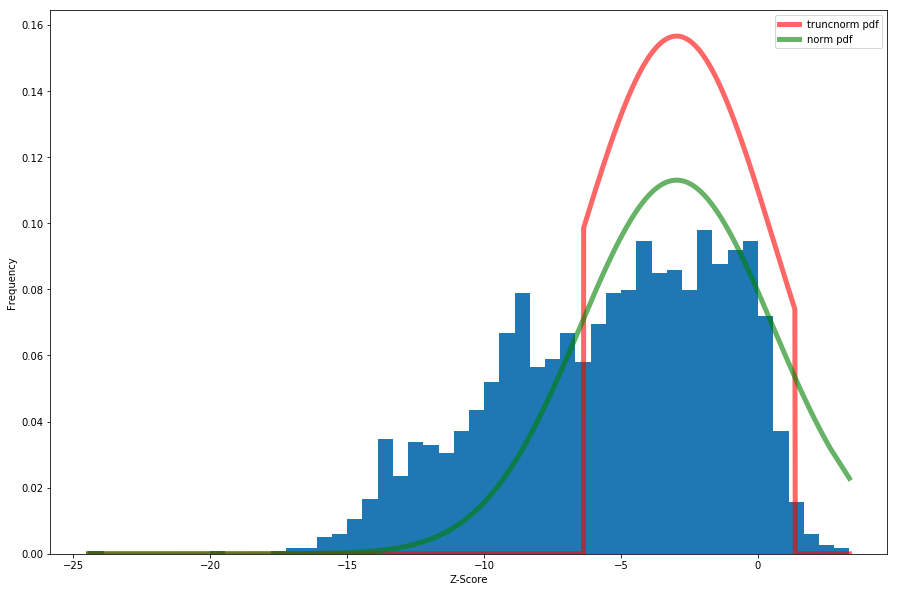

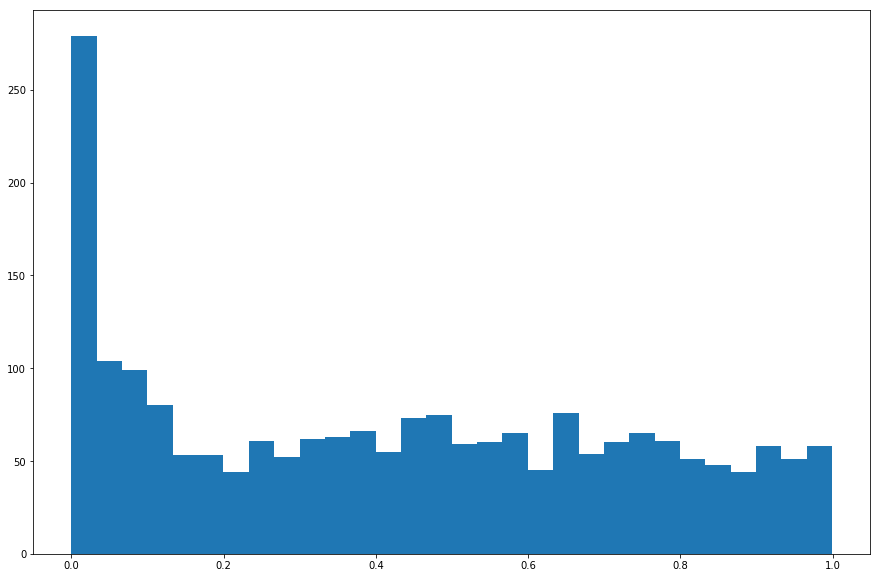

[1.15405454e-09 1.47606663e-06 3.27068085e-05 7.32670429e-05
 1.00715961e-04 1.59578807e-04 1.61506282e-04 2.15063364e-04
 2.44692539e-04 2.97676278e-04 3.01609238e-04 3.06241085e-04
 3.27593771e-04 3.79011890e-04 4.47268225e-04 4.59508510e-04
 5.11423743e-04 5.78657485e-04 5.99392872e-04 6.27970867e-04]
number of pathways with p < 0.001: 28


In [16]:
failures_of_null_anova('8', 38, 99)

[-17.40250118 -17.1360966  -17.13605926 ...   2.93432457   3.00675783
   3.22513698]
Quantiles calculated: -3.747773078817006, 2.931699477980507
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2632.848303260692
            Iterations: 52
            Function evaluations: 383
            Gradient evaluations: 52
[-1.43025026  2.66524524 -1.41513289  1.63093148]


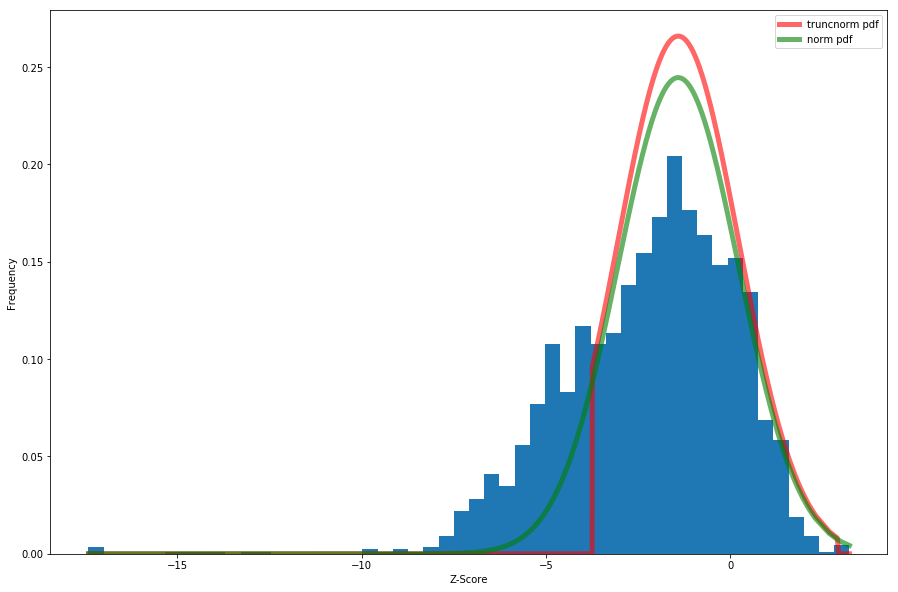

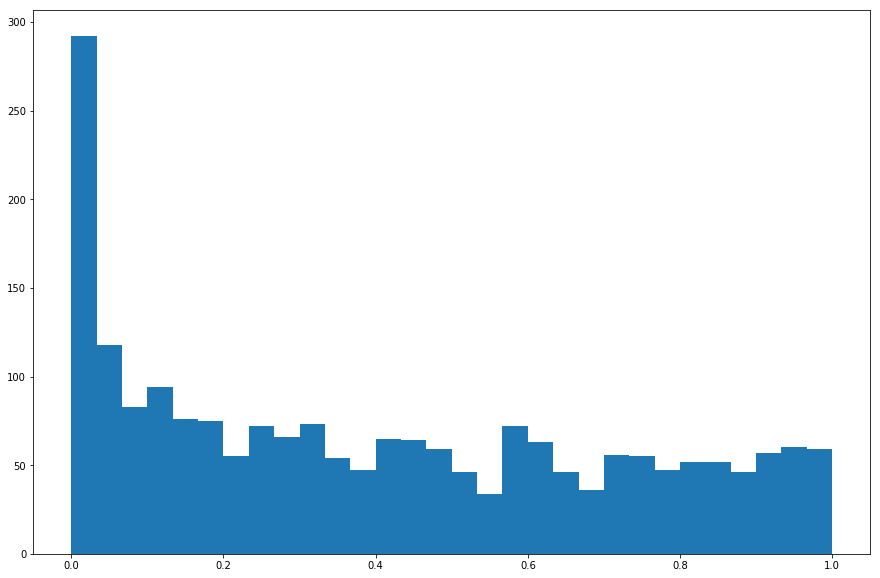

[1.09724753e-22 5.45829095e-22 5.45950840e-22 5.68829272e-17
 2.91491437e-16 4.43338450e-15 1.00158442e-14 1.13405730e-12
 2.23448152e-12 2.21588579e-07 2.88160371e-07 2.02475949e-06
 2.52086772e-06 2.98836584e-06 1.30046631e-05 3.39972521e-05
 5.73725772e-05 6.70091376e-05 7.18783260e-05 7.49883590e-05]
number of pathways with p < 0.001: 60


In [17]:
failures_of_null_anova('9', 25, 99.9)

[-34.66291375 -34.66291179 -33.31015597 ...   2.28558475   2.6496367
   2.70303907]
Quantiles calculated: -11.727118245400064, 2.7019320354627903
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3529.824314514408
            Iterations: 129
            Function evaluations: 980
            Gradient evaluations: 129
[-1.37690872  1.60442589 -5.06316141  4.83979564]


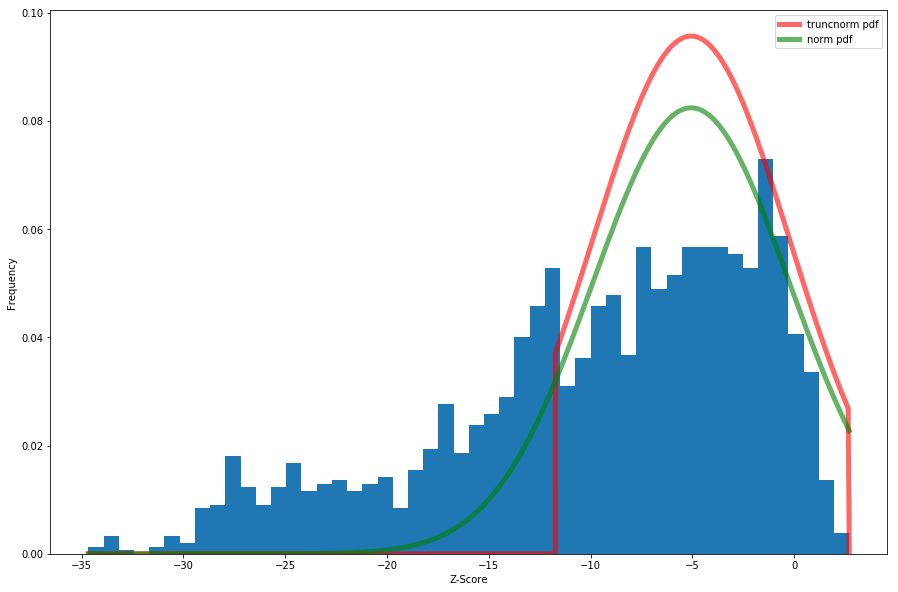

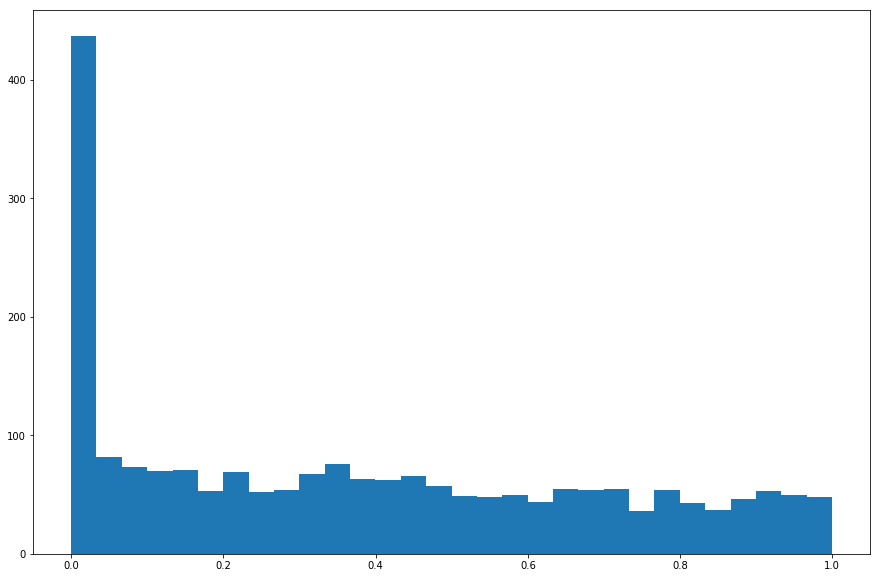

[9.60077754e-10 9.60080184e-10 5.33400045e-09 5.33401851e-09
 5.33402395e-09 5.33403005e-09 5.33403879e-09 7.08925684e-09
 4.72317893e-08 5.46464919e-08 9.68910763e-08 1.34396321e-07
 1.66032184e-07 1.78822509e-07 2.06868560e-07 3.42889453e-07
 3.48626371e-07 4.43729412e-07 4.86346653e-07 5.59032623e-07]
number of pathways with p < 0.001: 231


In [18]:
failures_of_null_anova('10', 37, 99.999)

In [19]:
gsea_df = pd.read_csv('../exp/GSEA_qvalues.csv', index_col = 0)
gsea_df_counts = {}

for column in gsea_df.columns:
    columnshape = gsea_df[gsea_df[column] >= 3].shape[0]
    gsea_df_counts[column] = columnshape

adjusted_q_counts = {}
for cluster in clusterframes:
    columnshape = clusterframes[cluster][clusterframes[cluster]['adjusted q-values'] <= 0.001].shape[0]
    adjusted_q_counts[cluster] = columnshape
    
wall_df = pd.read_csv('../exp/pathway_qvalues.csv', index_col = 0)
wal_df = wall_df.loc[:, wall_df.columns.str.endswith('q-values')]
new_name = {}
for i in wal_df.columns:
    new_i = i.strip('Cluster q-values')
    new_name[i] = new_i
    
wal_df = wal_df.rename(columns =new_name)

wall_df_counts = {}
for column in wal_df.columns:
    columnshape = wal_df[wal_df[column] >= 3].shape[0]
    #print(columnshape)
    wall_df_counts[column] = columnshape

wall_df_counts['4ER-'] = wall_df_counts.pop('4ER')
print(wall_df_counts)
print(adjusted_q_counts)

{'1': 828, '10': 1615, '2': 78, '3': 1048, '4ER+': 1303, '5': 839, '6': 290, '7': 1126, '8': 1354, '9': 723, '4ER-': 1029}
{'4ER+': 150, '9': 14, '7': 65, '3': 126, '8': 1, '10': 151, '1': 254, '2': 6, '5': 37, '4ER-': 21, '6': 2}


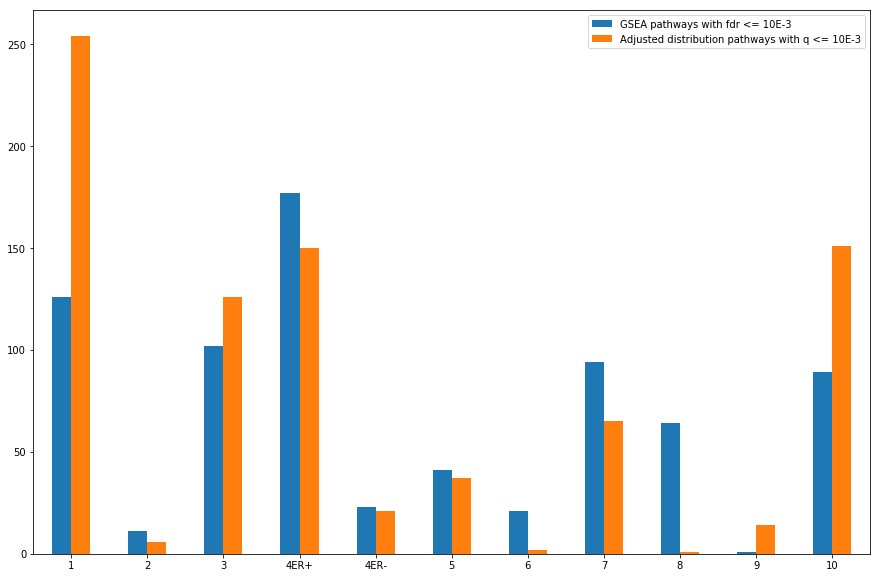

In [20]:
full_df = pd.DataFrame({'GSEA pathways with fdr <= 10E-3': gsea_df_counts, 
                        #'Mann whitney pathways with q-value <= 10E-3': significant_pathways,
                        #'Wall pathways with q <= 10E-3': wall_df_counts,
                        'Adjusted distribution pathways with q <= 10E-3': adjusted_q_counts})
ax = full_df.plot.bar(rot=0, figsize=(15, 10))
plt.show()

In [14]:
clusterframes['2']

,p-values,qvalues,adjusted p-value,adjusted q-values,log adjusted p-value,cluster 2 log adjusted q-value
Signaling by Insulin receptor,3.788784e-12,7.857937e-09,2.718106e-07,0.000527,6.565734,3.278292
Iron uptake and transport,2.132196e-11,1.475806e-08,8.415853e-07,0.000527,6.074902,3.278292
Transferrin endocytosis and recycling,2.429206e-11,1.475806e-08,9.163528e-07,0.000527,6.037937,3.278292
Insulin receptor recycling,2.846298e-11,1.475806e-08,1.016153e-06,0.000527,5.993041,3.278292
Amino acids regulate mTORC1,5.325704e-11,2.209102e-08,1.528606e-06,0.000634,5.815704,3.197866
...,...,...,...,...,...,...
Defects in cobalamin (B12) metabolism,1.907954e-01,3.750803e-01,9.957816e-01,0.997262,0.001836,0.001191
RNA polymerase II transcribes snRNA genes,1.941424e-01,3.800880e-01,9.958194e-01,0.997262,0.001819,0.001191
The citric acid (TCA) cycle and respiratory electron transport,1.931494e-01,3.786313e-01,9.983019e-01,0.998881,0.000738,0.000486
Fanconi Anemia Pathway,1.919028e-01,3.767860e-01,9.985704e-01,0.998881,0.000621,0.000486


In [92]:
full_clusterframe = pd.DataFrame(index=clusterframes['1'].index)
full_clusterframe
for i in clusterframes:
    print(type(i))
    series = clusterframes[i][f'cluster {i} log adjusted q-value']
    full_clusterframe = pd.concat([full_clusterframe, series.reindex(full_clusterframe.index)], axis=1)

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [93]:
full_clusterframe

,cluster 4ER+ log adjusted q-value,cluster 9 log adjusted q-value,cluster 7 log adjusted q-value,cluster 3 log adjusted q-value,cluster 8 log adjusted q-value,cluster 10 log adjusted q-value,cluster 1 log adjusted q-value,cluster 2 log adjusted q-value,cluster 5 log adjusted q-value,cluster 4ER- log adjusted q-value,cluster 6 log adjusted q-value
RMTs methylate histone arginines,0.698640,0.111659,0.322094,0.040119,0.078162,0.169529,10.706196,0.030682,0.063161,0.071160,0.004852
HDMs demethylate histones,0.333846,0.120411,0.175178,0.072959,0.090587,0.049368,9.776219,0.035932,0.014554,0.209273,0.004852
Senescence-Associated Secretory Phenotype (SASP),0.815178,0.000613,0.067733,0.051720,0.020596,0.167263,9.776219,0.186046,0.030516,0.502973,0.004852
Cellular Senescence,1.233537,0.061290,0.007162,0.040882,0.038640,0.166999,9.776219,0.033053,0.319598,0.153031,0.002017
Nucleosome assembly,1.503196,0.098823,0.203657,0.825492,0.188819,0.016740,9.686448,0.147700,0.168611,0.168442,0.004852
...,...,...,...,...,...,...,...,...,...,...,...
Biosynthesis of protectin and resolvin conjugates in tissue regeneration (PCTR and RCTR),0.481181,0.004142,0.087568,0.233363,0.113587,0.046953,0.001178,0.138268,0.419899,0.153031,0.002017
Loss of proteins required for interphase microtubule organization from the centrosome,2.589696,0.107127,0.386672,3.014592,0.042884,1.190299,0.001178,0.364180,1.347083,0.253997,0.004852
FGFR3c ligand binding and activation,0.118791,0.006101,0.605357,0.094210,0.001435,0.073665,0.001178,0.013832,0.187120,0.083868,0.004852
Axon guidance,0.416213,0.540006,0.034273,0.021864,0.055437,0.154019,0.001178,0.008446,0.014636,0.097603,0.004852


In [75]:
full_clusterframe.to_csv('../exp/adjusted_distributions_intclusts.csv')